# Final Performance Evaluation of Semi-supervised Autoencoders

In [1]:
%matplotlib inline
import sys; sys.path.append('..')

import tensorflow as tf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, os.path as p
import subprocess
import warnings
import itertools
import re
import operator

from IPython.display import display, display_html
import ipywidgets as widgets

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.linear_assignment_ import linear_assignment

from keras.models import load_model
from tensorflow_models.utils.custom_layers import KCompetitive, TiedDense
from tensorflow_models.data_loaders import TfIdfGenerator, load_newsgroups
from tensorflow_models.base import Config

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = 12,8
plt.rcParams['font.size'] = 16
sns.set_style('whitegrid')
warnings.simplefilter('ignore')
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
PROJECT_ROOT = "/home/quent/Documents/repos/ai/deep-learning/tensorflow-models/"
RESULTS_DIR = "/run/media/quent/Data/ssl-results/eval_results"
OUTPUT_ROOT = p.join(PROJECT_ROOT, "outputs/ssl-results/eval_results/20190503_1824/")
RESULTS_FILES = [f for f in os.listdir(RESULTS_DIR) if f.startswith('final')]
FIGURES_DIR = "/home/quent/Documents/repos/latex/master-thesis/figures/"

## Performance on supervised task

### Load the evaluation results

In [4]:
def load_and_parse(filename):
    # Define parsing function
    def parse(line):
        key_value_pairs = list((comp.split('=') for comp in line.strip().split(',')))
        return dict(filter(lambda p: len(p) == 2, key_value_pairs))
    
    # Parse file and store in dataframe
    with open(filename) as f:
        df = pd.DataFrame(list(map(parse, f.readlines()))).set_index(['run_id'])
        
    # Convert strings 'false' and 'true' to booleans
    if 'unsupervised' in df:
        df['unsupervised'] = df['unsupervised'].map({'false': False, 'true': True}).fillna(False)

    # Convert remaining types
    column_dtypes = {'examples_per_class': int, 'model_name': str, 'unsupervised': bool}
    float_columns = {col: float for col in df.columns if col not in column_dtypes}
    column_dtypes = dict(**column_dtypes, **float_columns)
    for col, dtype in column_dtypes.items():
        if col in df and dtype:
            df[col] = df[col].astype(dtype)

    return df

def load_all_runs():
    results = pd.DataFrame()
    for i, filename in enumerate(RESULTS_FILES):
        results = pd.concat([results, load_and_parse(p.join(RESULTS_DIR, filename)).assign(run=i)], axis=0)
    return results

def plot_results(df, plotting_func=sns.swarmplot, metric='test_f1_score'):
    model_names = df.model_name.unique()
    n_models = len(model_names)
    nrows, ncols = int(np.ceil(n_models / 3)), 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows * 3), squeeze=False, sharex=True, sharey=True)
    for i, model_name in enumerate(model_names):
        ax = axs[i // ncols, i % ncols]
        plotting_func(x='examples_per_class', y=metric, hue='run', data=df[df.model_name == model_name], ax=ax)
        ax.set_xlabel('')
        ax.set_title(model_name)
    plt.tight_layout()

results = load_all_runs()
# plot_results(results)
results = results[results.run != 2].drop('run', axis=1).drop_duplicates()

### Plot performance evaluation

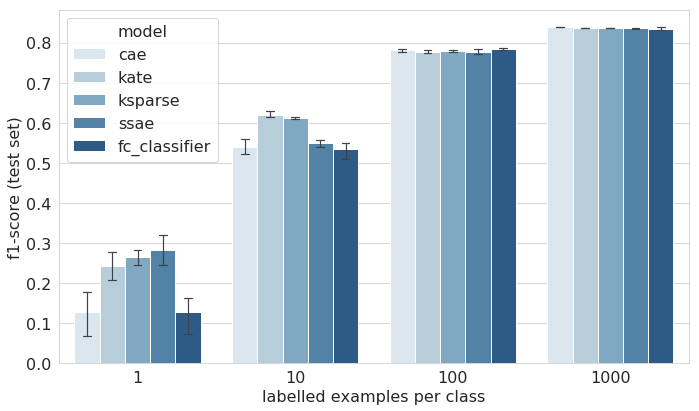

In [5]:
def plot_reg(df, **plot_kw):
    
    n_classes, test_size = 20, 9051
    df['labelled data'] = (df['examples_per_class'] * n_classes / test_size).map(lambda x: min(x, 1))
    for model_name in df.model_name.unique():
        sns.regplot(
            x='labelled data', 
            y='test_f1_score', 
            data=df[(df.model_name == model_name)], 
            label=model_name, 
            **plot_kw)

    plt.xlim((-0.05, 1.05))
    plt.legend()

def plot_boxes(results):
    fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
    # ax = plt.subplot()
    for epc, ax in zip([1000, 100, 10, 1], axs):
        sns.boxplot(x='model_name', y='test_f1_score', data=results[results.examples_per_class == epc], ax=ax)
        ax.set_title('{:,} labelled examples'.format(min(9051, epc * 20)))
        ax.set_xlabel('')
        ax.set_ylabel('f1-score (test set)')

    plt.tight_layout()

def plot_bars(results):
    ax = plt.subplot()
    sns.barplot(x='examples_per_class', y='test_f1_score', hue='model', data=results.rename(columns={'model_name': 'model'}),
                palette='Blues', saturation=0.6, errwidth=1.2, errcolor='#3d424b', capsize=0.05, ax=ax)

    ax.set_xlabel('labelled examples per class'); ax.set_ylabel('f1-score (test set)')
    ax.get_figure().set_size_inches((10, 6))
    plt.tight_layout()
    plt.savefig(p.join(FIGURES_DIR, 'f1score_comparison.eps'))
    
results_supervised = results[results.unsupervised == False]
# plot_boxes(results_supervised)
# sns.swarmplot(x='examples_per_class', y='test_f1_score', hue='model_name', data=results_supervised);
# plot_reg(results_supervised, logx=True, fit_reg=True, scatter_kws={'alpha': 0.2})
plot_bars(results_supervised)

In [6]:
# (results[(results.examples_per_class == 1) & (results.unsupervised == False)]
#  .groupby('model_name').agg(['mean', 'std'])[['test_f1_score', 'test_accuracy']])

### Statistical testing of which is best

In [7]:
from scipy.stats import ttest_ind

def test_score(df, epc, model, other=None, metric='test_f1_score'):
    epc = df[(df.examples_per_class == epc)]
    x1 = epc.loc[epc.model_name == model, metric]
    mask_x2 = epc.model_name != model if other is None else epc.model_name == model
    x2 = epc.loc[mask_x2, metric]
    return ttest_ind(x1, x2)

print(test_score(results_supervised, 1, 'ssae'))
print(test_score(results_supervised, 10, 'kate'))

Ttest_indResult(statistic=2.3288832033652507, pvalue=0.03171479803909586)
Ttest_indResult(statistic=3.226360132791184, pvalue=0.004958072102745734)


### Latex table of performance comparison

In [8]:
raw_scores = """
TF-IDF + LR        &   0.8319 &  0.0000 \\
CNN-rand           &   0.7693 &  0.0061 \\
CNN-non-static     &   0.8215 &  0.0052 \\
LSTM               &   0.6571 &  0.0152 \\
LSTM (pretrain)    &   0.7543 &  0.0172 \\
Bi-LSTM            &   0.7318 &  0.0185 \\
PV-DBOW            &   0.7436 &  0.0018 \\
PV-DM              &   0.5114 &  0.0022 \\
PTE                &   0.7674 &  0.0029 \\
fastText           &   0.7938 &  0.0030 \\
fastText (bigrams) &   0.7967 &  0.0029 \\
SWEM               &   0.8516 &  0.0029 \\
LEAM               &   0.8191 &  0.0024 \\
Graph-CNN-C        &   0.8142 &  0.0032 \\
Text GCN           &   0.8634 &  0.0009 \\
"""

def parse(line):
    def convert(val):
        val = val.strip()
        if val.isnumeric():
            return float(val)
        return val

    return {key: convert(val) for key, val in zip(["model", "Average", "StDev"], line.strip().split("&"))}

def format_model_name(s):
    if 'fc_' in s:
        return s, 'FC classifier'
    elif s == 'ksparse':
        return s, 'K-sparse (semi-sup.)'
    else:
        return s, s.upper() + ' (semi-sup.)'

published_scores = (pd.DataFrame(list(filter(lambda x: len(x) > 1, map(parse, raw_scores.split("\\")))))
                    .set_index('model')
                    .astype(float))

ours = (results.loc[results.examples_per_class == 1000, ['model_name', 'test_accuracy']]
        .groupby(['model_name'])
        .agg(['mean', 'std'])
        .droplevel(axis=1, level=0)
        .rename(columns={'mean': 'Average', 'std': 'StDev'}, 
                index=dict(map(format_model_name, results.model_name.unique())))
        .sort_values('Average', ascending=False))

scores = pd.concat([published_scores, ours], axis=0)
scores['Rank'] = scores['Average'].rank(ascending=False).astype(int)
print(scores.to_latex(column_format='lrrr'))
# scores

\begin{tabular}{lrrr}
\toprule
{} &  Average &  StDev &  Rank \\
\midrule
TF-IDF + LR          &   0.8319 & 0.0000 &     8 \\
CNN-rand             &   0.7693 & 0.0061 &    14 \\
CNN-non-static       &   0.8215 & 0.0052 &     9 \\
LSTM                 &   0.6571 & 0.0152 &    19 \\
LSTM (pretrain)      &   0.7543 & 0.0172 &    16 \\
Bi-LSTM              &   0.7318 & 0.0185 &    18 \\
PV-DBOW              &   0.7436 & 0.0018 &    17 \\
PV-DM                &   0.5114 & 0.0022 &    20 \\
PTE                  &   0.7674 & 0.0029 &    15 \\
fastText             &   0.7938 & 0.0030 &    13 \\
fastText (bigrams)   &   0.7967 & 0.0029 &    12 \\
SWEM                 &   0.8516 & 0.0029 &     2 \\
LEAM                 &   0.8191 & 0.0024 &    10 \\
Graph-CNN-C          &   0.8142 & 0.0032 &    11 \\
Text GCN             &   0.8634 & 0.0009 &     1 \\
CAE (semi-sup.)      &   0.8457 & 0.0004 &     3 \\
KATE (semi-sup.)     &   0.8436 & 0.0010 &     4 \\
K-sparse (semi-sup.) &   0.8428 & 0.0003 &

## Performance on unsupervised tasks

### Plot unsupervised scores

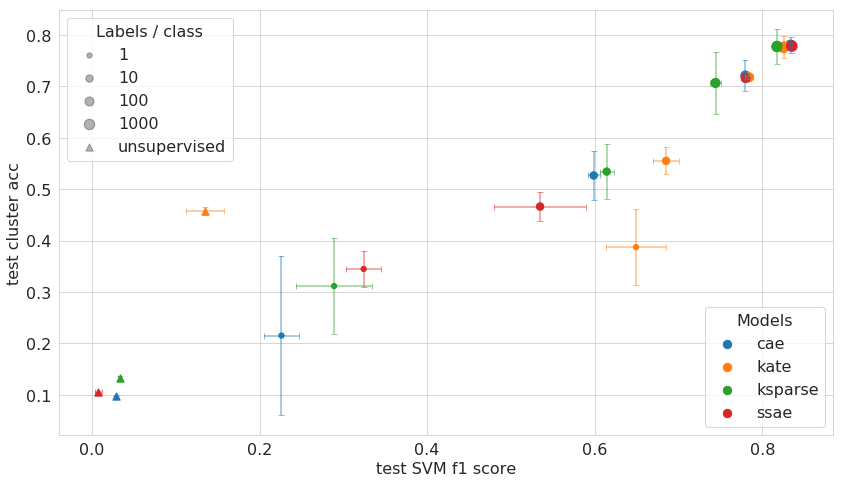

In [9]:
def plot_unsupervised_scores(scores, errorbars=False, filename=None):
    scores = scores.copy()
    scores = scores.loc[scores.model_name != 'fc_classifier']
    scores.update(scores.loc[scores.unsupervised, 'model_name'].map(lambda s: s + ' (uns.)'))

    metrics = ['test_SVM_f1_score', 'test_cluster_acc']
    models = (sorted(filter(lambda s: 'uns' not in s, scores.model_name.unique()))
              + sorted(filter(lambda s: 'uns' in s, scores.model_name.unique())))

    palette = sns.color_palette('tab10', n_colors=len(models) // 2)
    palette = list(palette) * 2
    color_mapping = {m: palette[i] for i, m in enumerate(models)}
    colors = scores['model_name'].map(color_mapping)
    scores.loc[scores.unsupervised, 'examples_per_class'] = 8
    def get_size(epc): return (np.log10(epc) + 1) * 28

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    if errorbars:
        scores = scores.groupby(['model_name', 'examples_per_class']).agg(['mean', 'std'])[metrics]

        error_bars = [
            ax.errorbar(scores.xs(model)[(metrics[0], 'mean')],
                        scores.xs(model)[(metrics[1], 'mean')],
                        scores.xs(model)[(metrics[0], 'std')],
                        scores.xs(model)[(metrics[1], 'std')],
                        fmt='none',
                        ecolor=color_mapping[model], 
                        capsize=3, 
                        alpha=0.5)
            for model in models
        ]

        points_collection = [
            ax.scatter(scores.xs(model)[(metrics[0], 'mean')],
                       scores.xs(model)[(metrics[1], 'mean')],
                       color=color_mapping[model],
                       marker='^' if 'uns' in model else 'o',
    #                    alpha=0.8,
                       s=scores.xs(model).index.get_level_values('examples_per_class').map(get_size),
                       label=model)
            for model in models
        ]

        
    else:
        scores = scores.set_index(['model_name', 'examples_per_class'])[metrics]
        points_collection = [
            ax.scatter(scores.xs(model)[metrics[0]],
                       scores.xs(model)[metrics[1]],
                       color=color_mapping[model],
                       marker='^' if 'uns' in model else 'o',
                       alpha=0.8,
                       s=scores.xs(model).index.get_level_values('examples_per_class').map(get_size),
                       label=model)
            for model in models
        ]
    
    model_legend = plt.legend(handles=points_collection[:len(points_collection) // 2],
                              #frameon=False,
#                               ncol=2,
#                               bbox_to_anchor=(0.23, 1),
                              loc=4,
#                               labelspacing=0.85,
                              title='Models')


    ax.add_artist(model_legend)

    sizes_collection = [
        ax.scatter([], [], c='k', alpha=0.3, s=get_size(epc), label=str(epc))
        for epc in [1, 10, 100, 1000]
    ] + [ax.scatter([], [], c='k', marker='^', alpha=0.3, s=get_size(8), label='unsupervised')] 

    size_legend = plt.legend(handles=sizes_collection,
                             scatterpoints=1,
                             #frameon=False,
                             loc=2,
                             #labelspacing=1,
                             title='Labels / class')

    for label, func in zip(metrics, [ax.set_xlabel, ax.set_ylabel]):
        func(label.replace('_', ' '))
        
    plt.tight_layout()
    (plt.show() or plt.close()) if filename is None else plt.savefig(filename)
    
plot_unsupervised_scores(results.loc[results.model_name != 'fc_classifier'], errorbars=True, 
                         filename=p.join(FIGURES_DIR, 'unsup_scores.pdf')
                        )

In [537]:
(results[(results.unsupervised == False) & (results.examples_per_class == 1000) & (results.model_name== 'kate')])

examples_per_class model_name  test_AMI  test_NMI  \
run_id                                                             
20190502_0659                1000       kate    0.7360    0.7414   
20190503_1930                1000       kate    0.7383    0.7404   
20190504_0311                1000       kate    0.7383    0.7404   
20190504_1019                1000       kate    0.7387    0.7408   

               test_SVM_f1_score  test_accuracy  test_cluster_acc  \
run_id                                                              
20190502_0659             0.7927         0.8429            0.7775   
20190503_1930             0.8363         0.8429            0.7730   
20190504_0311             0.8347         0.8433            0.7758   
20190504_1019             0.8376         0.8451            0.7768   

               test_f1_score  test_mse unsupervised  val_AMI  val_NMI  \
run_id                                                                  
20190502_0659         0.8361    0.0001        False   0.8618   0.8665   
20190503_1930         0.8359    0.0000        False   0.8273   0.8321   
20190504_0311         0.8369    0.0000        False   0.8226   0.8276   
20190504_1019         0.8382    0.0000        False   0.8272   0.8321   

               val_SVM_f1_score  val_accuracy  val_cluster_acc  val_f1_score  \
run_id                                                                         
20190502_0659            0.6289        0.9218           0.9143        0.9199   
20190503_1930            0.9093        0.9266           0.8436        0.9249   
20190504_0311            0.9077        0.9249           0.8414        0.9237   
20190504_1019            0.9116        0.9249           0.8458        0.9230   

               val_mse  
run_id                  
20190502_0659   0.0000  
20190503_1930   0.0000  
20190504_0311   0.0000  
20190504_1019   0.0000

## Parameters Exploration 

### Select model

In [43]:
import logging

def sh(cmd):
    with subprocess.Popen(cmd.split(), stdout=subprocess.PIPE) as proc:
        out = proc.stdout.read()
    return out.decode('utf-8')

class OutputWidgetHandler(logging.Handler):
    """ Custom logging handler sending logs to an output widget """

    def __init__(self, *args, **kwargs):
        super(OutputWidgetHandler, self).__init__(*args, **kwargs)
        self.out = widgets.Output(layout={'width': '100%', 'border': '1px solid black'})

    def emit(self, record):
        """ Overload of logging.Handler method """
        formatted_record = self.format(record)
        new_output = {'name': 'stdout', 'output_type': 'stream', 'text': formatted_record+'\n'}
        self.out.outputs = (new_output, ) # + self.out.outputs

    def show_logs(self): display(self.out)

    def clear_logs(self): self.out.clear_output()
            
            
class ModelSelector:

    model_location_pattern = r"\/(\d{8}_\d{4})\/"
    checkpoint_file = 'model_checkpoint.ckpt'
    weight_file = 'model_weights.h5'
    encodings_file = 'encodings.csv'
    training_file = 'training.txt'
    output_format = '%(asctime)s  - [%(levelname)s] %(message)s'
    setting_file_pattern = r'settings\s+.*?\/(\w+\-?\_?\w+.yaml)'
    
    def __init__(self, root, loglevel=logging.INFO):
        self.root = root
        self.loglevel = loglevel
        
        self.dropdown = self.build_dropdown()
        self.logger, self.handler = self.build_output()
        self.container = self.build_container()
        
        self._model_weights = None
        self._model_config = None
        
        self.dropdown.observe(self.on_change)
        display(self.container)

    @property
    def path(self):
        return p.dirname(self._model_weights)
        
    @property
    def weights(self):
        return self._model_weights
    
    @property
    def config(self):
        return self._model_config
    
    @property
    def evaluation_dir(self):
        if 'evaluate' in os.listdir(self.path):
            eval_dir = p.join(self.path, 'evaluate')
            return p.join(eval_dir, os.listdir(eval_dir)[0])
        
    def build_container(self):
        dropdown_container = widgets.HBox([widgets.Label('Model:'), self.dropdown])
        return widgets.VBox([dropdown_container, self.handler.out])
        
    def build_dropdown(self):
        cmd = "find {} -type f -name {}".format(self.root, self.weight_file)
        paths = sh(cmd).strip().split('\n')
        options = sorted(map(self.parse_path, paths), reverse=True, key=operator.itemgetter(0))
        return widgets.Dropdown(options=options, value=None, layout={'width': '200px'})

    def build_output(self):
        logger = logging.getLogger(__name__)
        handler = OutputWidgetHandler()
        handler.setFormatter(logging.Formatter(self.output_format))
        logger.addHandler(handler)
        logger.setLevel(self.loglevel)
        return logger, handler
        
    def parse_path(self, path):
        relpath = path.replace(self.root, '')
        optname = re.search(self.model_location_pattern, relpath).group(1)
        return optname, path
    
    def get_config(self):
        training_log_file = p.join(self.path, self.training_file)
        regex = re.compile(self.setting_file_pattern)
        if not p.exists(training_log_file):
            raise FileNotFoundError(training_log_file)
        with open(training_log_file) as f:
            training_log = f.read()
            m = regex.search(training_log)
            if m:
                config_file, = m.groups(1)
                return Config(config_file, overwrite={'output_dir': self.path})
            else:
                raise FileNotFoundError('config file not found')

    def on_change(self, change):
        if change['type'] == 'change' and change['name'] == 'value':
            self._model_weights = change['new']
            self._model_config = self.get_config()
            self.handler.clear_logs()
            self.logger.info("Model checkpoint: {}\n{}".format(self._model_weights, self._model_config))


model = ModelSelector(p.join(PROJECT_ROOT, 'outputs'))

In [45]:
def softmax(ar):
    return np.exp(ar) / np.exp(ar).sum(axis=1, keepdims=True)

def kld(p, q):
    q = np.clip(q, 1e-7, 1e+7)
    p = np.clip(p, 1e-7, 1e+7)
    return - np.sum(p * np.log(q / p))
        
def heatmap(mat, **kwargs):
    ax = kwargs.get('ax')
    if not ax:
        fig = plt.figure(figsize=(14,12))
        ax = fig.add_subplot()
    kwargs['ax'] = ax
    ax = sns.heatmap(mat, **kwargs)
    if kwargs.get('annot'):
        format_text = lambda t: t.set_text("{:.0f}".format(float(t.get_text()))) if float(t.get_text()) > 0 else ""
        list(map(format_text, ax.texts))
    
def intraclass_heatmap(mat, labels, **kwargs):
    assert not any(k in kwargs for k in ('vmin', 'vmax', 'ax'))
    n_classes = labels.max() + 1
    ncols = n_classes // 5
    nrows = n_classes // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
#     print('all', mat.mean(), mat.std())
    for c in range(n_classes):
        selection = np.arange(len(labels))[labels == c]
        subset = mat[np.meshgrid(selection, selection)]
#         print(c, subset.mean(), subset.std())
        ax = axs[c % 5, c // 5]
        heatmap(subset, cbar=False, vmin=mat.min(), vmax=mat.max(), ax=ax, **kwargs)
        ax.set_title('Class {}'.format(c))
    
def interclass_kld(mat):
    N = mat.shape[1]
    res = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            res[i, j] = kld(mat[:, i], mat[:, j])
    return pd.DataFrame(res)

### Load data

In [46]:
generator = TfIdfGenerator(load_newsgroups, model.config)
X, y, _ = generator.test
n_classes = generator.n_classes
features = np.array(generator.vectorizer.get_feature_names())
target_names = tn = np.array(generator.target_names)
encoding_dim = model.config.encoder_dims[-1]

Training set loaded in 43.74 s: 9051 training examples, 2263 validation examples
Supervised examples: 20 out of 9051
Testing set loaded in 28.39 s: 7532 testing examples
Total time: 72.13 s
An empty vectorizer was instantiated.
Num features: 12690


### Load model

In [48]:
def build_model(model_checkpoint, model_class=None):
    K.clear_session()
    if model_checkpoint.endswith('ckpt'):
        try:
            return load_model(model_checkpoint, custom_objects={'KCompetitive': KCompetitive})
        except Exception as err:
            print('The model could not be loaded ({}). Try using weight files in the future...'.format(err))
    else:
#         import importlib
#         assert model_class is not None
#         m = importlib.import(model_class)
#         gen = m.Generator()
        raise NotImplementedError

def predict(model, X, y):

    predictions = model.predict(X)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        encodings = sess.run(model.get_layer('encoding').output, feed_dict={model.inputs[0]: X})
        
    return predictions, encodings

def load_encodings(dirname):
    filename = p.join(dirname, 'encodings.csv')
    data = np.genfromtxt(filename, delimiter=',')
    return data[:, 0].astype(int), data[:, 1:]

def load_predictions(dirname):
    filename = p.join(dirname, 'predictions.csv')
    data = np.genfromtxt(filename, delimiter=',')
    return data
    
def load_clusters(dirname):
    filename = p.join(dirname, 'clusters.csv')
    data = np.genfromtxt(filename, delimiter=',')[1:, :]
    return [data[:, i].astype(int) for i in (1, 2)]

def sample(*args, labels=None, n_samples=100, balanced=False):
    assert all([labels is not None, balanced]) or not balanced
    N = len(args[0])
    if balanced:
        all_indices = np.arange(len(labels))
        n_classes = len(np.unique(labels))
        n_each = n_samples // n_classes
        idx = np.concatenate(
            [np.random.choice(all_indices[labels == i], n_each, replace=False) for i in range(n_classes)], axis=0)
        if n_each * n_classes != n_samples:
            choices = np.array(list(set(np.arange(len(X))) - set(idx)))
            remaining = np.random.choice(choices, n_samples - n_each * n_classes, replace=False)
            idx = np.concatenate([idx, remaining], axis=0)
    else:
        idx = np.random.choice(np.arange(len(X)), n_samples, replace=False)
    
    if labels is not None:
        args = list(args)
        args.append(labels)
        
    return tuple([ar[idx] for ar in args])


# model = load_model()
# predictions, encodings = predict(model, X, y)
# Xs, ys, ps, Es = sample(X, y, predictions, encodings)
# Xs, ys, Es = sample(X, y, encodings)

dirname = model.evaluation_dir
labels, encodings = load_encodings(dirname)
# predictions = load_predictions(dirname)
# hard_predictions = predictions.argmax(1)
clusters, _ = load_clusters(dirname)
# Xs, ps, Es, cs, ys = sample(X, predictions, encodings, clusters, labels=labels, balanced=True)
Xs, Es, cs, ys = sample(X, encodings, clusters, labels=labels, balanced=True)
# Xs, Es, ys = sample(X, encodings, labels=labels, balanced=True)

### Average values of encodings

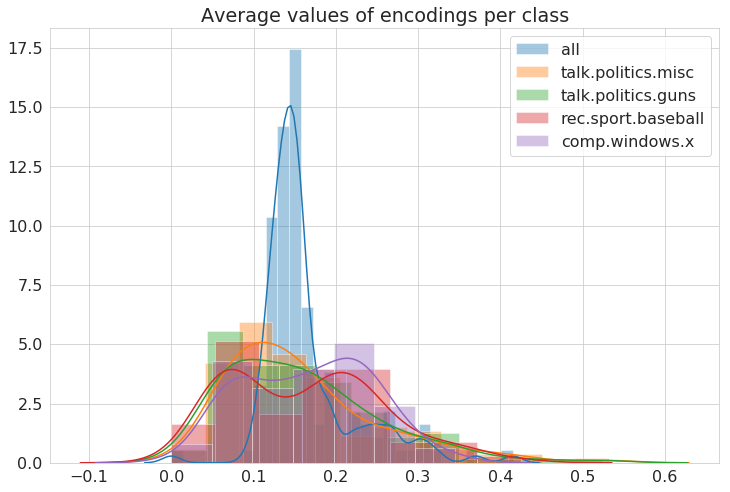

In [49]:
sns.distplot(encodings.mean(axis=0), label='all')
selection = np.random.randint(0, 19, 4)
for i in selection:
    sns.distplot(encodings[labels == i].mean(axis=0), label=target_names[i])
plt.legend()
plt.title('Average values of encodings per class');

# mean_encoding = np.stack([encodings[labels == i].mean(axis=0) for i in range(20)], axis=1)
# fig = plt.figure(figsize)
# sns.heatmap(mean_encoding.T)

# np.stack([encodings[labels == i].std(axis=0) for i in range(20)], axis=1)

### Average encodings over classes

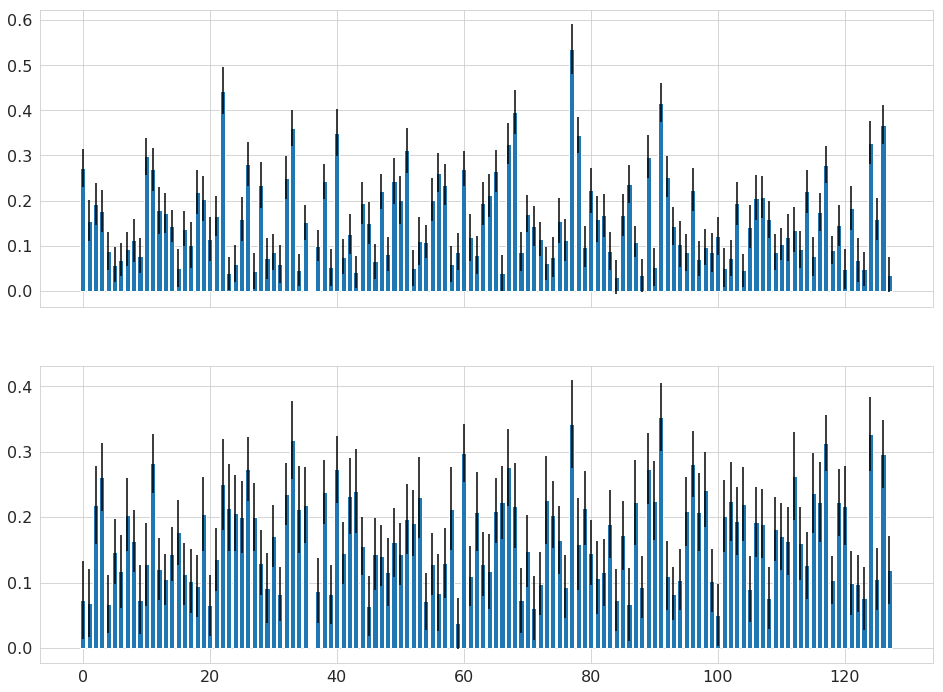

In [50]:
nplots = 2
fig, axs = plt.subplots(nplots, 1, figsize=(16, 6 * n_classes), sharex=True, squeeze=False)
for label, ax in enumerate(axs[:, 0]):
    class_encodings = pd.DataFrame(encodings[labels == label])
    ax.bar(np.arange(128), class_encodings.mean(), yerr=class_encodings.std())
#     ax.set_xticks(np.arange(128))

# ax.bar(np.arange(128), encodings.mean(axis=0), encodings.std(axis=0), color='orange')

### Same but overlapping

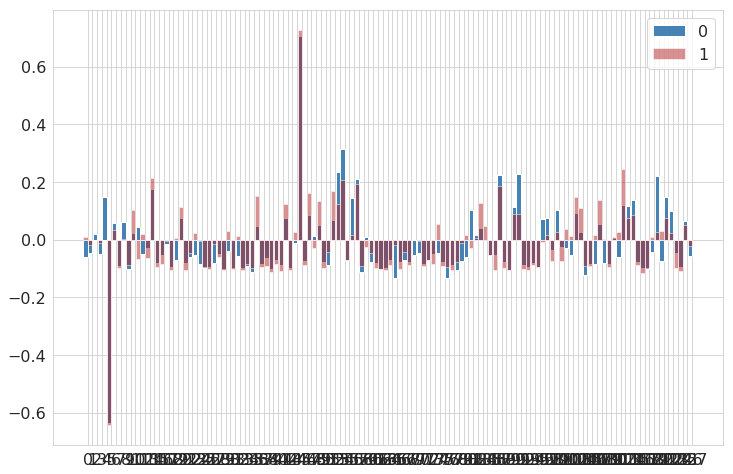

In [17]:
def overlapped_bar(df, show=False, width=0.9, alpha=.5,
                   title='', xlabel='', ylabel='', **plot_kwargs):
    """Like a stacked bar chart except bars on top of each other with transparency"""
    xlabel = xlabel or df.index.name
    N = len(df)
    M = len(df.columns)
    indices = np.arange(N)
    colors = ['steelblue', 'firebrick', 'darksage', 'goldenrod', 'gray'] * int(M / 5. + 1)
    for i, label, color in zip(range(M), df.columns, colors):
        kwargs = plot_kwargs
        kwargs.update({'color': color, 'label': label})
        plt.bar(indices, df[label], width=width, alpha=alpha if i else 1, **kwargs)
        plt.xticks(indices + .5 * width,
                   ['{}'.format(idx) for idx in df.index.values])
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)

overlapped_bar(pd.DataFrame(np.stack([encodings[labels == 0].mean(axis=0), encodings.mean(axis=0)], axis=1)))

### Most predictive encoding for a specific class

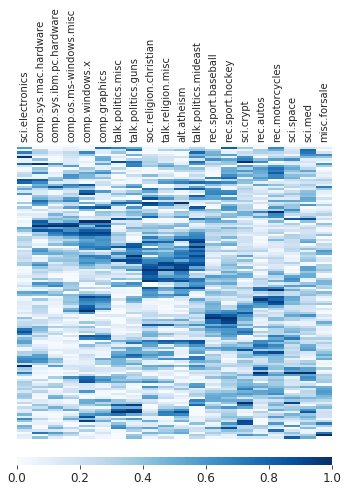

In [55]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram

def hierarchical_clustering(data, method='single', metric='cosine', ax=None, display=None):

    ax = ax or plt.subplot()

    Z = linkage(data, method=method, metric=metric, optimal_ordering=True)
    dn1 = dendrogram(Z, ax=ax, orientation='left')
    
    feature_ordering = [int(tl.get_text()) for tl in ax.get_yticklabels()]
#     ax.set_yticklabels(target_names[feature_ordering], ha='right', va='bottom', size='small')
    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.set_xticks([])
    if not display:
        plt.close()
    return feature_ordering

def plot_most_predictive(X, labels, target_names, thresh=1e-5, xord=None, yord=None):
    scores = pd.DataFrame(columns=pd.MultiIndex.from_product([target_names, ('score', 'pvalue')]))
    for i in range(20):
        anova = SelectKBest()
        anova.fit(X, labels == i)
#         scores[target_names[i]] = np.where(anova.pvalues_ < thresh, anova.scores_, np.zeros_like(anova.scores_))
#         sns.distplot(anova.scores_, label=target_names[i])
#         scores[target_names[i]] = anova.scores_ * (1 - anova.pvalues_)
        scores[(target_names[i], 'score')] = anova.scores_
        scores[(target_names[i], 'pvalue')] = anova.pvalues_

#     plt.legend()
    scores_norm = MinMaxScaler().fit_transform(scores.xs('score', axis=1, level=1))
    probability_mask = 1 - scores.xs('pvalue', axis=1, level=1)
    scores = scores_norm * probability_mask
    if xord is not None:
        scores = scores.iloc[xord, :]
    if yord is not None:
        scores = scores.iloc[:, yord]

    fig, (ax, cax) = plt.subplots(nrows=2, figsize=(5, 5.025),  gridspec_kw={"height_ratios":[1, 0.025]})
    sns.heatmap(scores, cmap='Blues', cbar=False, ax=ax)
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(length=0)
    cb = fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
    cb.outline.set_linewidth(0)
    ax.set_yticks([])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10, rotation_mode='anchor', ha='left', va='center')
    plt.gcf().set_size_inches((5, 7))
    return scores
    
plt.rcParams['font.size'] = 12
# scores = plot_most_predictive(encodings, labels, target_names)
scores = plot_most_predictive(encodings, labels, target_names, xord=encoding_ordering, yord=class_ordering)
plt.tight_layout()
# plt.savefig(p.join(FIGURES_DIR, 'encoding_predictive_power.eps'))

In [54]:
class_ordering = hierarchical_clustering(scores.T)
encoding_ordering = hierarchical_clustering(scores)
plt.close()

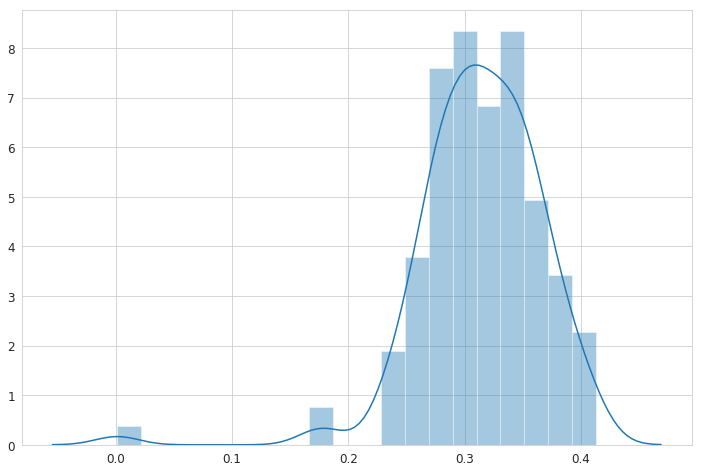

In [56]:
sns.distplot(scores.mean(axis=1), bins=20)

### Best ordering for the features and encodings

### Cosine similarities of encodings as a function of the classes

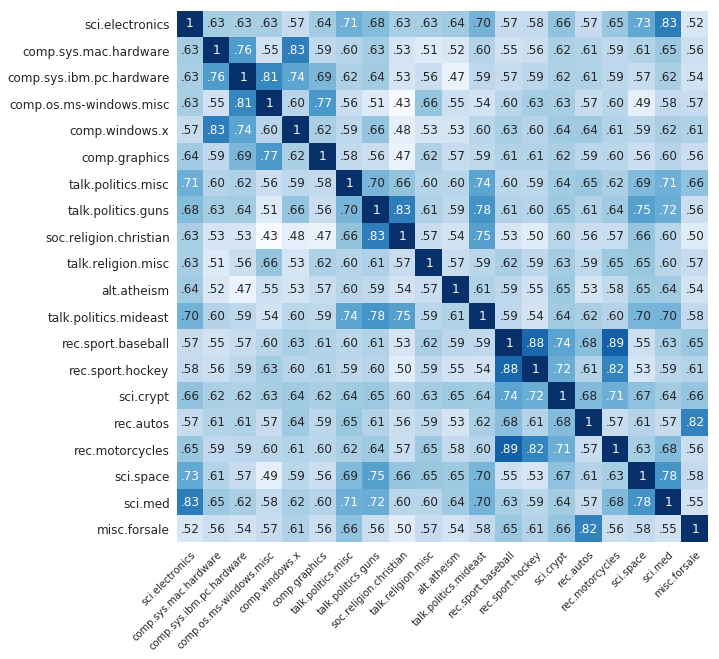

In [59]:
from sklearn.metrics.pairwise import cosine_distances

feature_names = target_names[class_ordering]
sorted_scores = scores.iloc[:, class_ordering]
similarity_matrix = pd.DataFrame(1 - cosine_distances(sorted_scores.T), index=feature_names, columns=feature_names)
plt.figure(figsize=(10,10))
sns.heatmap(similarity_matrix, cmap='Blues', square=True, cbar_kws={'shrink': 0.82}, 
            annot=True, annot_kws={'fontsize': 'medium'}, cbar=False)
annot_format = lambda t: t.set_text('{:.2f}'.format(float(t.get_text())).lstrip('0')) if t.get_text() != "1" else "1"
ax = plt.gca()
list(map(annot_format, ax.texts));
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, rotation_mode='anchor');
# ax.set_yticks([])
plt.tight_layout()
# plt.subplots_adjust(left=0.2)
# plt.savefig(p.join(FIGURES_DIR, 'encoding_similarities.eps'))

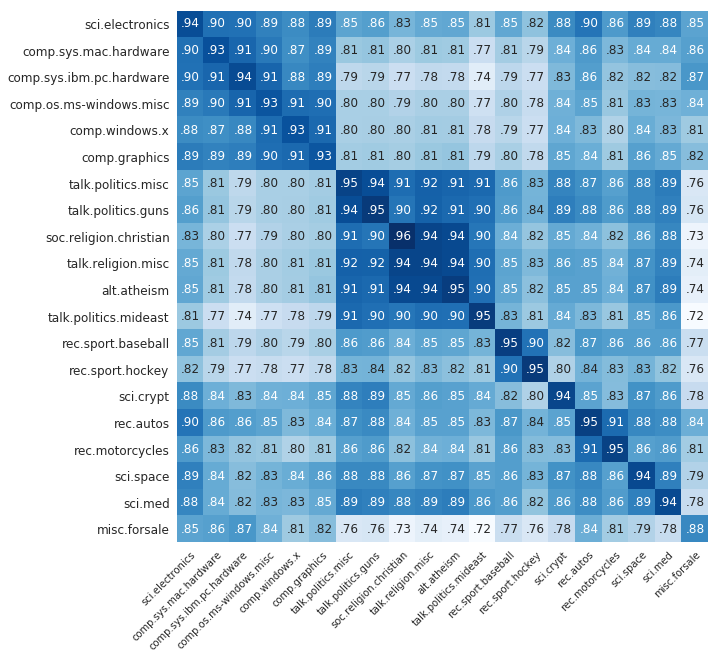

In [60]:
from sklearn.metrics.pairwise import euclidean_distances

def cosine_similarity(*args):
    return 1 - cosine_distances(*args)

def class_encoding_similarity(encodings, labels, metric=cosine_similarity, target_names=None, ordering=None):
    n_classes = len(np.unique(labels))
    distances = np.zeros(shape=(n_classes, n_classes))
    for i in range(n_classes):
        for j in range(i, n_classes):
            dist = metric(encodings[labels == i], encodings[labels == j]).mean()
            distances[i, j] = distances[j, i] = dist

    distances = pd.DataFrame(distances, index=target_names, columns=target_names)
    
    if ordering:
        distances = distances.iloc[ordering, ordering]
            
    return distances
            
def plot_heatmap(matrix, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
    
    sns.heatmap(matrix, cmap='Blues', 
#                 vmin=0, vmax=1, 
                square=True, annot=True, 
                annot_kws={'fontsize': 'medium'}, cbar=False)
    
    def annot_format(text):
        value = text.get_text()
        return "1" if value == "1" else text.set_text('{:.2f}'.format(float(value)).lstrip('0'))

    list(map(annot_format, ax.texts))
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, rotation_mode='anchor')


similarities = class_encoding_similarity(encodings, labels, 
                                         metric=cosine_similarity, 
                                         target_names=target_names, 
                                         ordering=class_ordering)

plot_heatmap(similarities)
plt.tight_layout()
# plt.savefig(p.join(FIGURES_DIR, 'encoding_class_similarities.eps'))

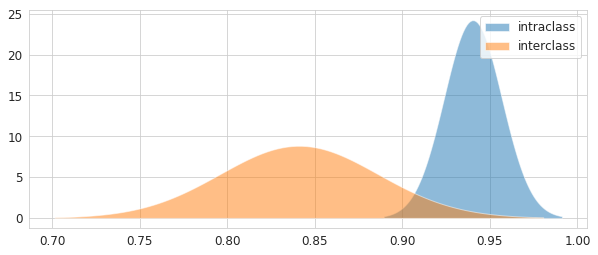

In [75]:
from scipy.stats import norm


def plot_normal(array, ax=None, label=None):
    ax = ax or plt.subplot()
    loc, scale = norm.fit(array)
    params = {'loc': loc, 'scale': scale}
    x = np.linspace(norm.ppf(0.001, **params), norm.ppf(0.999, **params), 100)
    ax.fill_between(x, norm.pdf(x, **params), alpha=0.5, label=label)


def plot_intra_vs_inter(intra, inter, plot_func=sns.distplot, plot_kw=None):
    plt.figure(figsize=(10,4))
    plot_kw = plot_kw or {}
    plot_func(intra, label='intraclass', **plot_kw)
    plot_func(inter, label='interclass', **plot_kw)
    plt.legend()
    
intraclass_similarities = np.array([similarities.iloc[i, i] for i in range(n_classes)])
interclass_similarities = np.array([similarities.iloc[i, j] for i in range(n_classes) for j in range(i+1, n_classes)])
# plot_intra_vs_inter(intraclass_similarities, interclass_similarities, plot_kw={'bins': 10})
plot_intra_vs_inter(intraclass_similarities, interclass_similarities, plot_func=plot_normal)

In [251]:
# unsupervised_sims = [intraclass_similarities, interclass_similarities]
# semisupervised_sims_1 = [intraclass_similarities, interclass_similarities]
# semisupervised_sims_10 = [intraclass_similarities, interclass_similarities]
# semisupervised_sims_100 = [intraclass_similarities, interclass_similarities]
# semisupervised_sims_1000 = [intraclass_similarities, interclass_similarities]
similarities_collection = [unsupervised_sims, semisupervised_sims_1, 
                           semisupervised_sims_10, semisupervised_sims_100, semisupervised_sims_1000]

In [563]:
weights_encoder = load_weights(weight_file, layer_name='encoder_layer1')
weights_encoder[:, 0].max()

0.79696673

In [65]:
def load_topics(dirname, topic_indices=None, max_words=10):
    
    def parse_topic(topic):
        def convert(values):
            return values[0], float(values[1])
        
        key_value_pairs = list(map(convert, filter(lambda pair: len(pair) == 2, map(str.split, topic.split('\n')))))
        return key_value_pairs
    
    with open(p.join(dirname, 'topics.txt')) as f:
        raw_text = f.read()
        raw_topics = raw_text.split('\n\n')[:-1]
        topics = list(map(parse_topic, raw_topics))

#     topic_indices = topic_indices or np.random.randint(len(topics), size=10)
        
#     topics = pd.DataFrame(
#         np.stack([list(map(operator.itemgetter(0), topics[i])) for i in topic_indices], axis=1), 
#         columns=['topic{}'.format(i+1) for i in range(len(topic_indices))]).head(max_words)
    
    return topics

topics = load_topics(dirname, topic_indices=[0, 1, 6, 17, 23, 24, 45, 46, 47, 48])
# print(topics.to_latex(index=False))
topics[0]

[('health', 1.4100230932235718),
 ('jewish', 1.3755910396575928),
 ('bibl', 1.365300178527832),
 ('sexual', 1.3241575956344604),
 ('islam', 1.247388243675232),
 ('moral', 1.2382477521896362),
 ('predict', 1.2344497442245483),
 ('punish', 1.2320293188095093),
 ('religi', 1.2058128118515015),
 ('sport', 1.205168604850769),
 ('hendrick', 1.1716976165771484),
 ('religion', 1.169052004814148),
 ('arrog', 1.1545579433441162),
 ('theolog', 1.1295722723007202),
 ('gay', 1.1276612281799316),
 ('muslim', 1.1254968643188477),
 ('verdict', 1.1173133850097656),
 ('pittsburgh', 1.1162821054458618),
 ('dod', 1.1152366399765015),
 ('rec', 1.1098324060440063)]

In [67]:
topics[scores['sci.space'].sort_values().index[-1]]

[('cmo', 1.355836033821106),
 ('motor', 1.3547147512435913),
 ('compound', 1.3169426918029785),
 ('drain', 1.3028029203414917),
 ('henri', 1.2708100080490112),
 ('trigger', 1.2128435373306274),
 ('orbit', 1.2110627889633179),
 ('stomach', 1.2101433277130127),
 ('dod', 1.2058380842208862),
 ('foot', 1.2042226791381836),
 ('compon', 1.1818379163742065),
 ('crari', 1.1712828874588013),
 ('sensor', 1.1480408906936646),
 ('journal', 1.14219069480896),
 ('flavor', 1.1380934715270996),
 ('schemat', 1.1291126012802124),
 ('mileag', 1.1284584999084473),
 ('clh', 1.1200966835021973),
 ('waco', 1.1152268648147583),
 ('amateur', 1.1076680421829224)]

In [68]:
topic_selection = pd.DataFrame()
topic_ids = []
for target in scores:
    if target == 'sci.med':
        i = -2
    else:
        i = -1
    best_topics = scores[target].sort_values()
    best_topic = best_topics.index[i]
    while best_topic in topic_ids:
        i -= 1
        best_topic = best_topics.index[i]

    topic_selection[(best_topic, target)] = list(map(operator.itemgetter(0), topics[best_topic]))
    topic_ids.append(best_topic)
#         print("{}: {:.2f}".format(target, np.mean(list(map(operator.itemgetter(1), topics[best_topic])))))

topic_selection = (topic_selection.sort_index(axis=1)
#                    .head(18)
#                    .iloc[:, [0,1,2,3,4,5,6,7,10,11,12,15,16,17,18,19]]
                   .apply(lambda col: " ".join(col.values), axis=0)
                  )

# for (topic_id, target), words in topic_selection.iteritems():
#     print("\\textbf{{{}}} & {} & {} \\\\".format(topic_id, target, words))

topic_selection

(0, comp.os.ms-windows.misc)      health jewish bibl sexual islam moral predict ...
(10, comp.sys.ibm.pc.hardware)    billion judg weak motor social orbit goal defi...
(13, sci.med)                     dwyer alink xt orbit murder nhl mathew livesey...
(24, talk.politics.mideast)       clh covington judgement bike cryptographi tar ...
(25, sci.space)                   atheist theolog nhl clh chip wheel graphic upg...
(27, alt.atheism)                 armenian cup nhl armenia palestin gordon playo...
(28, rec.sport.hockey)            batf waco christian dealer altern crimin abid ...
(37, rec.autos)                   cmo motor compound drain henri trigger orbit s...
(44, rec.sport.baseball)          ide dx atheist clh gateway auto diseas scheme ...
(56, comp.sys.mac.hardware)       mph motor privaci sport injuri rec associ theo...
(58, talk.politics.misc)          clh algorithm team implement clipper launch ar...
(90, talk.religion.misc)          pixel hendrick circuit cramer powerbook bi

In [544]:
topics1000 = load_topics(p.join(RESULTS_DIR, "20190504_1019"))
topics1000

topic1     topic2  topic3   topic4   topic5     topic6   topic7  \
0  armenian     window  window   window  project        mac      dod   
1      isra      space  rutger  clipper    bison     govern      car   
2      arab     dealer  gather  encrypt  kolstad        god      gun   
3    israel     govern     clh    secur  circuit        war  firearm   
4     space        car   excel      dod   keypad       appl      bmw   
5     orbit  microsoft    atho     file     inov        fbi  atheism   
6      moon        gun    judg      car       hc  christian  circuit   
7     lunar       moon    mari      tap  inqmind  algorithm   rushdi   
8      appl        vlb  roland     code     imag   religion   window   
9     board     server    golf     bike       rs    encrypt      win   

      topic8    topic9   topic10  
0        mac        xr      sale  
1        car     board      game  
2  christian    hockey  armenian  
3     window     medic      arab  
4      space   greatli     white  
5     launch  interfac        pc  
6      offer   circuit   graphic  
7        god      team    comput  
8     intern      root   clinton  
9        gun      game      hous

In [527]:
for idx in range(weights.shape[1]):
    token_idx = np.argsort(weights[:, idx])[::-1][:10]
    print(weights[token_idx, idx])

[0.8438264  0.829756   0.8198333  0.7781327  0.7773846  0.7677138
 0.7385991  0.73813695 0.70672375 0.6862955 ]
[0.7627978  0.72767955 0.66347975 0.64331037 0.6237848  0.61624366
 0.59363043 0.56006134 0.556697   0.55130965]
[0.6130981  0.4864923  0.43952456 0.416048   0.41587532 0.41230723
 0.40731484 0.38926303 0.38593012 0.38198838]
[0.6234465  0.61679107 0.5862653  0.5809297  0.55135095 0.5478748
 0.52282673 0.5117106  0.50157183 0.49702162]
[0.77846634 0.76903975 0.7431184  0.73858863 0.7273042  0.714851
 0.71238637 0.69719976 0.68185604 0.6810487 ]
[0.8000045  0.7994034  0.73467404 0.697969   0.6822483  0.6761894
 0.6734309  0.6723333  0.64478356 0.6332178 ]
[0.75761694 0.6822327  0.609345   0.60415196 0.55963063 0.5268305
 0.5215768  0.51047194 0.50056577 0.4948146 ]
[0.8648244  0.7369568  0.69826883 0.68883264 0.6735814  0.6476427
 0.6368987  0.61252594 0.60570836 0.59325117]
[0.7530306  0.71010226 0.7036955  0.6951305  0.6880605  0.67340386
 0.67253387 0.65656966 0.647688   0.

In [522]:
weights[:, 0].max()

0.8438264

In [516]:
scores.iloc[0].sort_values()

misc.forsale               0.0000
sci.crypt                  0.0008
talk.politics.mideast      0.0181
alt.atheism                0.0524
rec.sport.hockey           0.0576
comp.sys.mac.hardware      0.0594
comp.graphics              0.0756
comp.windows.x             0.0772
comp.os.ms-windows.misc    0.0837
soc.religion.christian     0.0870
sci.space                  0.1065
rec.motorcycles            0.1542
comp.sys.ibm.pc.hardware   0.2024
rec.autos                  0.2044
talk.religion.misc         0.2866
sci.med                    0.3444
sci.electronics            0.4342
rec.sport.baseball         0.4939
talk.politics.misc         0.5664
talk.politics.guns         1.0000
Name: 114, dtype: float64

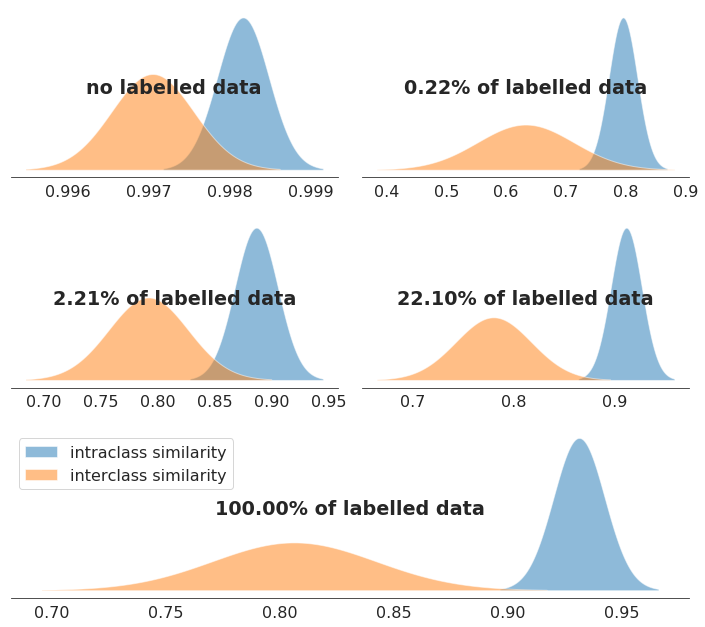

In [372]:
from matplotlib.gridspec import GridSpec


# dist_kws = {'bins': 10, 'fit': norm, 'kde': False, 'hist_kws': {"histtype": "step", "linewidth": 3}}
# fig, axs = plt.subplots(5, 1, figsize=(10,15))
plt.rcParams['font.size'] = 16
grid = GridSpec(3, 2, figure=plt.figure(figsize=(10,9)))

axs = [grid[0, 0], grid[0, 1], grid[1, 0], grid[1, 1], grid[2, :]]
axs = [plt.subplot(g) for g in axs]
sns.despine(left=True)

for i, ((intra, inter), ax) in enumerate(zip(similarities_collection, axs)):
#     sns.distplot(intra, label='intraclass similarity', ax=ax, **dist_kws)
#     sns.distplot(inter, label='interclass similarity', ax=ax, **dist_kws)
    plot_normal(intra, ax=ax, label='intraclass similarity')
    plot_normal(inter, ax=ax, label='interclass similarity')

    if not i: 
        title = 'no'
    else:
        title = '{:.2%} of'.format(min(1, 10**(i-1) * 20 / 9051))
    
    if i == 4:
        ax.legend(loc=2)
    
    def get_position(x, y):
        xpos = np.mean(ax.get_xlim()) + x * np.std(ax.get_xlim())
        ypos = np.mean(ax.get_ylim()) + y * np.std(ax.get_ylim())
        return xpos, ypos
    
    ax.text(*get_position(0, 0), title + ' labelled data', 
            fontsize='large', fontweight='bold', ha='center')
    
plt.setp(axs, yticks=[])        
plt.tight_layout()
plt.savefig(p.join(FIGURES_DIR, 'similarity_overlap.pdf'))

## Word distribution

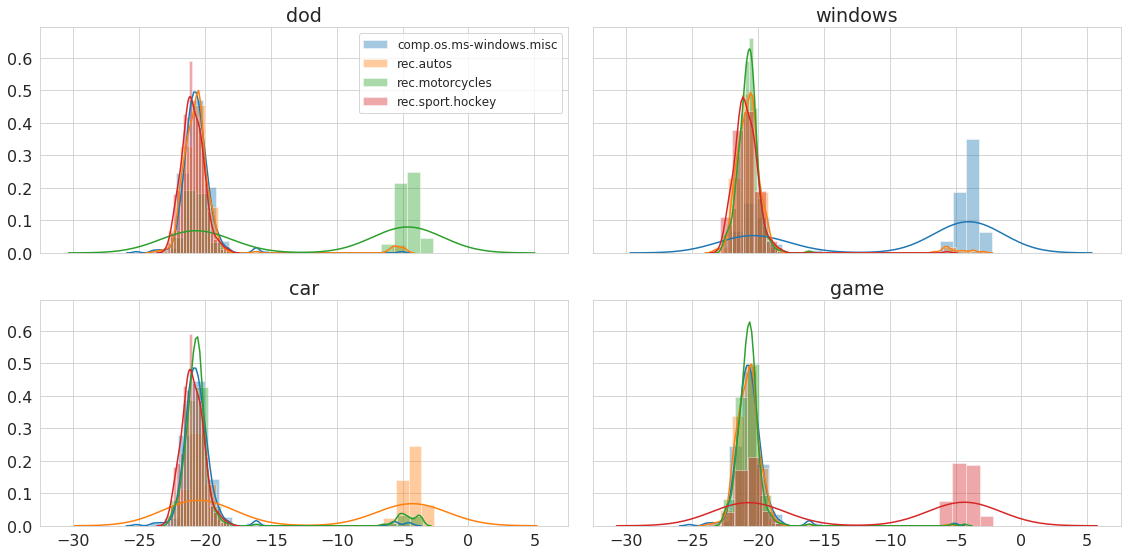

In [20]:
def plot_word_distribution(X, labels, features, word, classes, target_names=None, ax=None, legend=True):
    ax = ax or plt.subplot()
    for yi in classes:
        label = yi if target_names is None else target_names[yi]
        sns.distplot(np.log(np.squeeze(X[labels == yi, features == word])), bins=20, label=label, ax=ax)

    if legend:
        ax.legend(prop={'size': 12})    
    
def plot_best_words(X, labels, features, classes, num_words, target_names=None):
    anova = SelectKBest().fit(X, labels)
    scores = np.stack([anova.scores_, anova.pvalues_], axis=1)
    most_discriminant = (pd.DataFrame(scores, index=features, columns=['score', 'pvalue'])
                         .sort_values('score', ascending=False).head(num_words).index)
    
    fig, axs = plt.subplots(num_words // 2, 2, figsize=(16, 2 * num_words), sharex=True, sharey=True, squeeze=False)
    for i, word in enumerate(most_discriminant):
        ax = axs[i // 2, i % 2]
        plot_word_distribution(X, labels, features, word, classes, target_names, ax=ax, legend=(not i))
        ax.set_title(word)
        
    plt.tight_layout()
        
plot_best_words(X, labels, features, [2, 7, 8, 10], 4, target_names)

## Classification scores

In [21]:
print(metrics.classification_report(labels, hard_predictions, target_names=generator.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.26      0.16      0.20       319
           comp.graphics       0.11      0.09      0.10       389
 comp.os.ms-windows.misc       0.25      0.64      0.36       394
comp.sys.ibm.pc.hardware       0.25      0.43      0.31       392
   comp.sys.mac.hardware       0.41      0.29      0.34       385
          comp.windows.x       0.18      0.23      0.21       395
            misc.forsale       0.10      0.06      0.07       390
               rec.autos       0.49      0.59      0.53       396
         rec.motorcycles       0.55      0.32      0.40       398
      rec.sport.baseball       0.54      0.54      0.54       397
        rec.sport.hockey       0.22      0.05      0.08       399
               sci.crypt       0.33      0.65      0.44       396
         sci.electronics       0.17      0.21      0.19       393
                 sci.med       0.20      0.03      0.06       396
         

## Confusion matrix

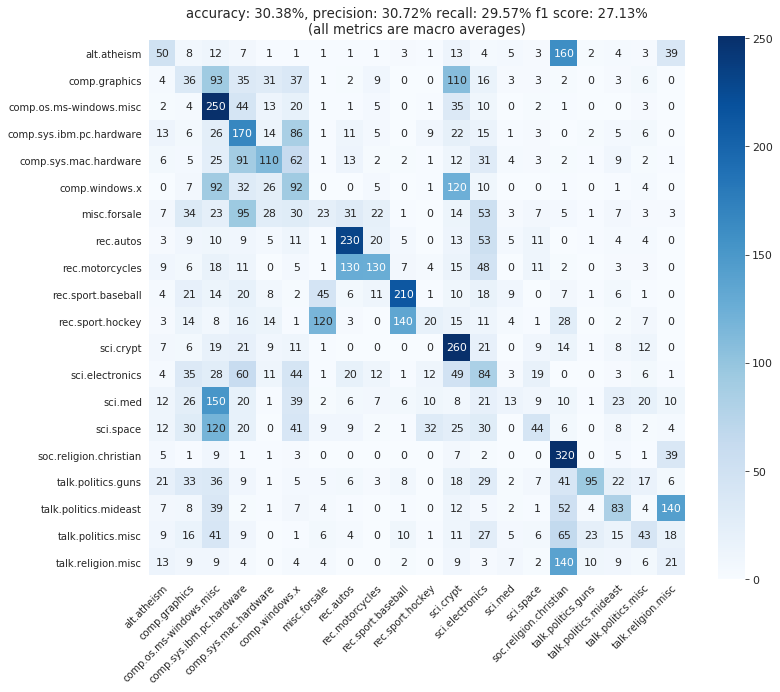

In [23]:
from tensorflow_models.utils.plotting import confusion_matrix

plt.rcParams['font.size'] = 11
confusion_matrix(labels, hard_predictions, filename=None, classnames=list(target_names));

## Outputs distribution

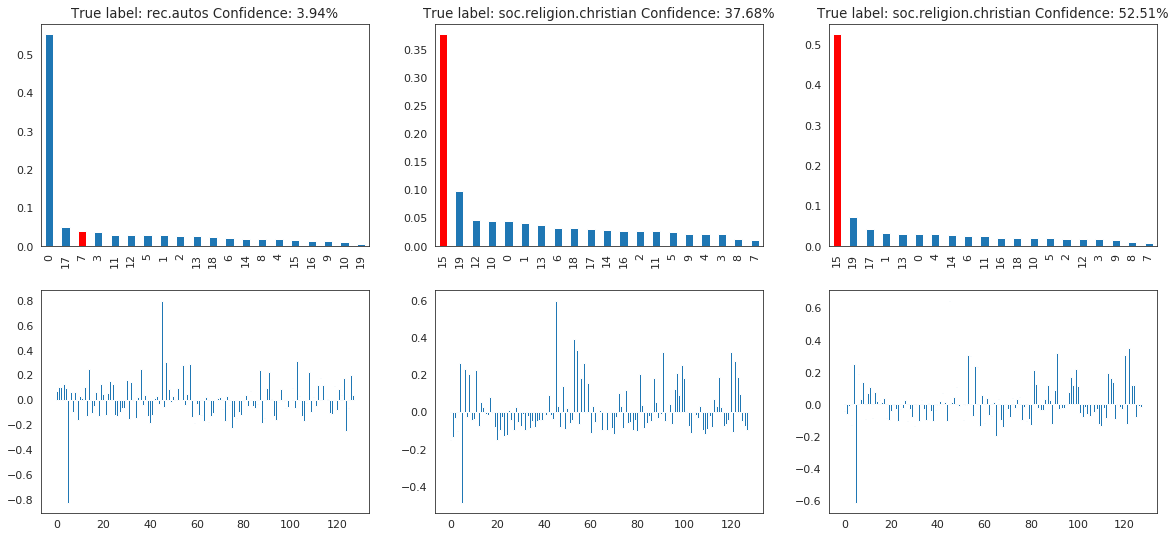

In [24]:
n_classes, encoding_dim = predictions.shape[1], encodings.shape[1]
fig, axs = plt.subplots(2,3, figsize=(20,9))
# idx = np.random.choice(np.arange(len(predictions)), replace=False, size=3)
idx = np.random.choice((-predictions.max(axis=1)).argsort()[:500], replace=False, size=3)
for i, (ax1, ax2) in enumerate(axs.T):
    true_label = int(labels[idx[i]])
    proba = pd.Series(predictions[idx[i]], name='yhat').sort_values(ascending=False).reset_index(drop=False)
    proba.plot.bar(x='index', y='yhat', ax=ax1)
    true_label_pred = proba[proba['index'] == true_label]
    ax1.patches[true_label_pred.index[0]].set_facecolor('red')
    ax1.set_xlabel('')
    ax1.get_legend().remove()
    ax1.set_title("True label: {} Confidence: {:.2%}".format(target_names[true_label], true_label_pred['yhat'].values[0]))
    ax2.bar(np.arange(encoding_dim), encodings[idx[i]])

## Least confident predictions

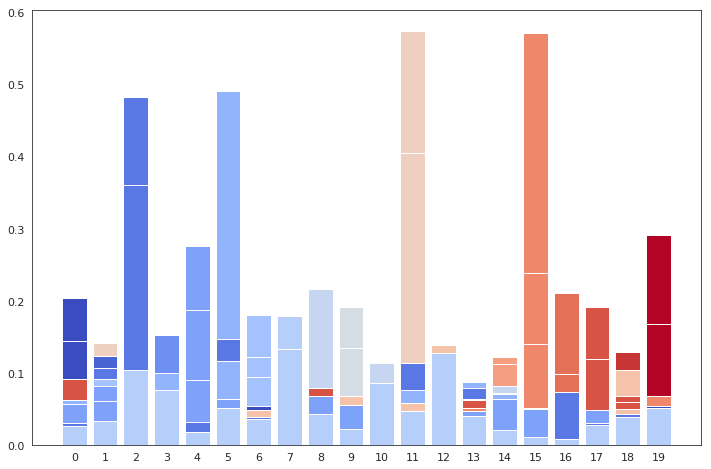

In [33]:
vmin, vmax = 1e-3, 1-1e-3
yhat = ps[np.vectorize(lambda x: vmin < x < vmax)(ps).any(axis=1)]
colors = plt.cm.coolwarm(np.linspace(0,1,n_classes))

fig, ax = plt.subplots(figsize=(12,8))
for i in range(len(yhat)):
    plt.bar(range(n_classes), yhat[i], color=colors[yhat[i].argmax()])
    
plt.xticks(range(20));

## Encoding similarity

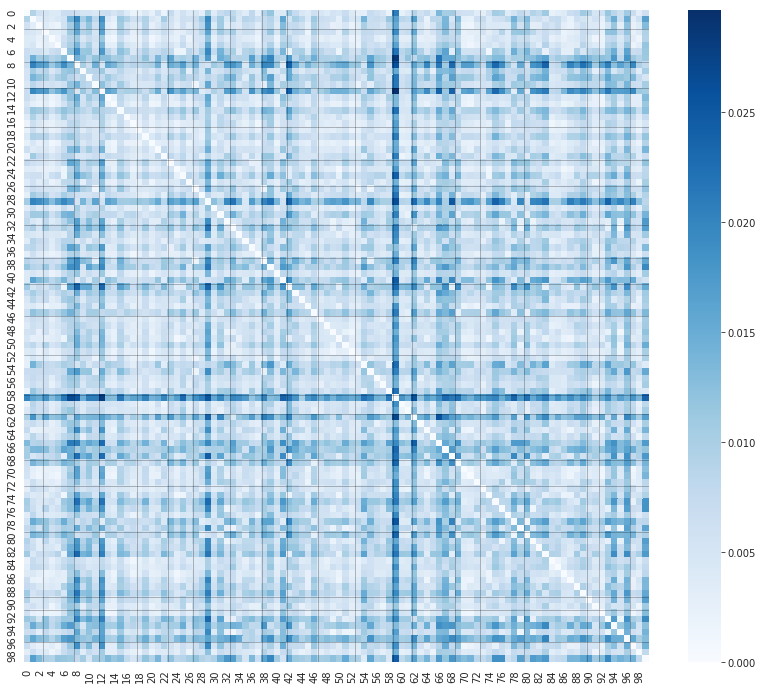

In [73]:
sorted_labels = np.array(sorted(ys))
# sorted_indices = np.argsort(ys.argmax(1))
soft_encodings = softmax(Es)[:, encoding_ordering]
element_wise_kld = interclass_kld(soft_encodings.T)
heatmap(element_wise_kld, cmap='Blues')
ax = plt.gca(); opts = dict(c='k', alpha=0.5, linewidth=0.5)
for el in np.arange(100)[np.concatenate([[False], np.diff(sorted_labels) == 1], axis=0)]:
    ax.axhline(el, **opts); ax.axvline(el, **opts)
# intraclass_heatmap(element_wise_kld.values, sorted_labels, cmap='Blues')

## Encoding clusters

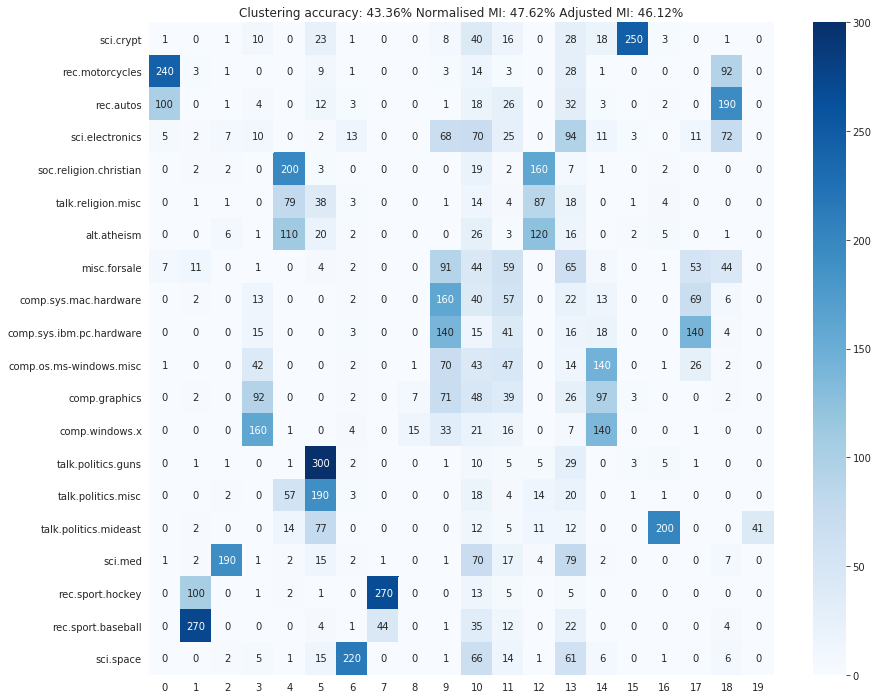

In [75]:
def clustering_accuracy(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

# kmeans = KMeans(n_clusters=n_classes, n_init=80, tol=1e-7, n_jobs=-1)
# clusters = kmeans.fit_predict(encodings)
# print("Iterations: {} Inertia: {:.4f}".format(kmeans.n_iter_, kmeans.inertia_))
# df = pd.DataFrame(np.stack([clusters, y.argmax(1), np.ones_like(clusters)], axis=1), 
#                   columns=['clusters', 'labels', 'count'])

df = pd.DataFrame(np.stack([clusters, labels, np.ones_like(clusters)], axis=1), columns=['clusters', 'labels', 'count'])

heatmap(
    df.pivot_table(index='labels', columns='clusters', values='count', aggfunc='count').iloc[class_ordering].fillna(0), 
    annot=True, cmap='Blues', yticklabels=target_names[class_ordering])

labels = y.argmax(1)
acc = clustering_accuracy(labels, clusters)
nmi = metrics.normalized_mutual_info_score(labels, clusters)
ari = metrics.adjusted_mutual_info_score(labels, clusters)
ax = plt.gca()
ax.set_title('Clustering accuracy: {:.2%} Normalised MI: {:.2%} Adjusted MI: {:.2%}'.format(acc, nmi, ari))
ax.set_xlabel(''); ax.set_ylabel('');

## Encoding's predictive power (overall)

In [ ]:
# anova_filter = SelectKBest().fit(enc_df, y.argmax(1) == i)
# anova_results[(i, 'score')] = anova_filter.scores_
# anova_results[(i, 'pvalue')] = anova_filter.pvalues_

## Encoding's predictive power per class

In [76]:
# def encoding_predictive_power(confidence_threshold=1e-3):
#     columns = pd.MultiIndex.from_product([range(n_classes), ['score', 'pvalue']], names=['classes', 'anova_scores'])
#     anova_results = pd.DataFrame(columns=columns)
    
#     for i in range(n_classes):
#         anova_filter = SelectKBest()
#         anova_filter.fit(encodings, y.argmax(1) == i)
#         anova_results[(i, 'score')] = anova_filter.scores_
#         anova_results[(i, 'pvalue')] = anova_filter.pvalues_
            
#     pred_confidence = list(pd.DataFrame({'label': predictions.argmax(1), 'confidence':predictions.max(axis=1)})
#                            .groupby('label')
#                            .mean()
#                            .sort_values('confidence', ascending=False)
#                            .index)
    
#     anova_results = (anova_results
#                      .rename_axis('encoding')
#                      .stack(level='classes')
#                      .swaplevel(0, 1)
#                      .sort_index(0))
    
#     most_significant = (anova_results
#                         .where(lambda df: df['pvalue'] < confidence_threshold)
#                         .dropna()
#                         .drop('pvalue', axis=1)
#                         .groupby(level='classes')
#                         .apply(lambda g: g.sort_values('score', ascending=False).iloc[pd.IndexSlice[np.r_[0:5, -5:0]]])
#                         .pipe(lambda df: df.set_index(df.index.droplevel(0)))
#                         .assign(best_encoding=(list(range(1, 6)) + list(range(-5, 0))) * n_classes)
#                         .reset_index()
#                         .pivot(index='classes', columns='best_encoding', values='encoding')) # ['encoding', 'score']
    
#     score_matrix = (anova_results                        
#                     .where(lambda df: df['pvalue'] < confidence_threshold)
#                     .fillna(0)
#                     .drop('pvalue', axis=1)
#                     .reset_index()
#                     .pivot(index='encoding', columns='classes', values='score')
#                     [pred_confidence]
#                     .sort_values(pred_confidence, axis=0, ascending=False)
#                    )
    
#     score_similarity = (anova_results
#                         .reset_index()
#                         .drop('pvalue', axis=1)
#                         .pivot(index='encoding', columns='classes', values='score'))
        
#     score_similarity = interclass_kld(np.abs(score_similarity.values))
    
#     heatmap(score_matrix, cmap='Blues')
#     heatmap(score_similarity, cmap='Blues', vmax=np.quantile(score_similarity, .9))
    
#     return score_similarity

# encoding_predictive_power(1e-2);

In [516]:
# enc_df = pd.DataFrame(encodings)
# # avg_encs = enc_df.groupby(y.argmax(1)).agg('mean').sort_values(0).T
# heatmap(avg_encs, cmap='RdBu_r', vmin=-3e-3, vmax=3e-3) #.unstack(level=1)
# enc_df.assign(labels=y.argmax(1)).sort_values(0)

### Load weights

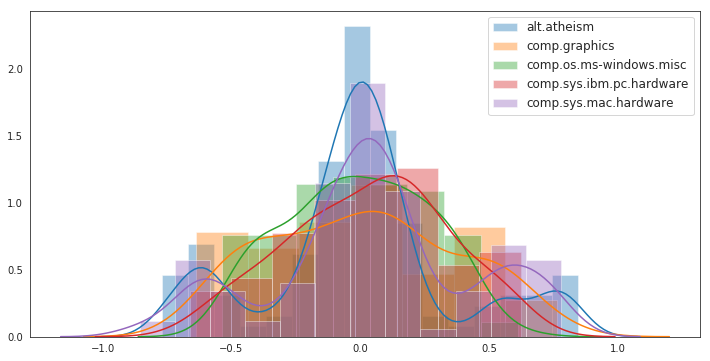

In [88]:
import h5py


def load_weights(filename, layer_name='classifier_layer'):
    with h5py.File(filename, 'r') as f:
        return f[layer_name][layer_name]['kernel:0'][()]

# weight_file = "../outputs/ssl-results/grid_search_results/grid_search_ssae_20190729/20190729_2240/model_weights.h5"
weight_file = p.join(p.dirname(dirname), "model_weights.h5")

weights = load_weights(weight_file)

def plot_weights
fig = plt.figure(figsize=(12,6))
for i in range(5):
    sns.distplot(weights[:, i], label=target_names[i])
plt.legend(prop={'size': 12});

# sns.distplot(weights[:, 0], bins=20);
# sns.pairplot(pd.DataFrame(weights[:, :5], columns=target_names[:5]));

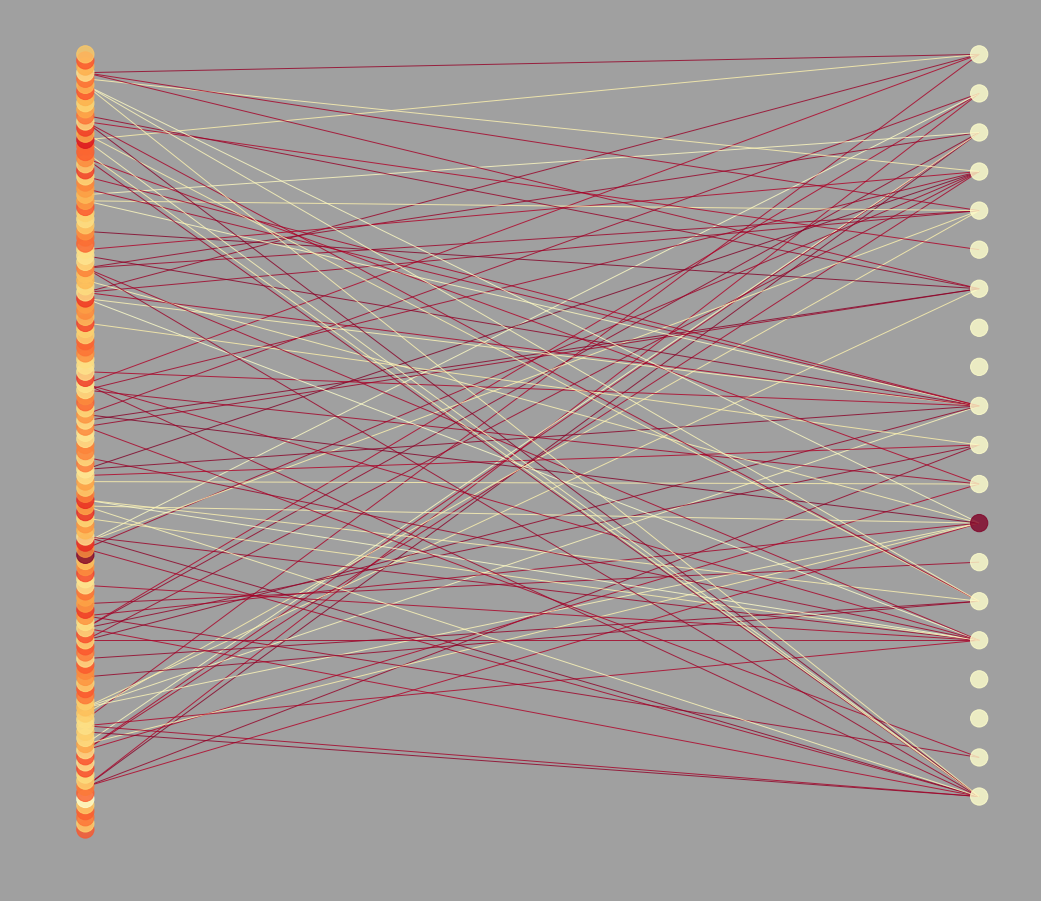

In [492]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from time import time
import warnings
import numpy as np
import seaborn as sns

def scale(array):
    if not type(array) == np.ndarray:
        array = np.array(array)
    return (array - array.min()) / (array.max() - array.min())

def build_graph(weights, thresh=None):
    dim_in, dim_out = weights.shape
    
    nodes_in = ["x{}".format(i) for i in range(dim_in)]
    nodes_out = ["y{}".format(i) for i in range(dim_out)]

    G = nx.DiGraph()
    G.add_nodes_from(nodes_in + nodes_out)
    for i in range(dim_in):
        for j in range(dim_out):
            if thresh is None or abs(weights[i, j]) > thresh:
                G.add_edge(nodes_in[i], nodes_out[j], weight=weights[i, j])
    
    return G, nodes_in, nodes_out
                        
def plot_network(weights, X=None, thresh=None):

    G, nodes_in, nodes_out = build_graph(weights, thresh=thresh)

    pos_x = {node: (0.1, (i+1)/len(nodes_in)) for i, node in enumerate(nodes_in)}
    pos_y = {node: (0.9, (i+1)/len(nodes_out)) for i, node in enumerate(nodes_out)}
    edges = [(u, v) for u, v in G.edges]
    edge_color = scale(list(map(lambda edge: G.get_edge_data(*edge)['weight'], edges)))
    
    if X is not None:
        a = np.dot(weights.T, X)
        y = np.exp(a) / np.exp(a).sum()
        node_color = np.concatenate([scale(X), y], axis=0)
    else:
        node_color = None

#     edges = [edge for i, edge in enumerate(edges) if abs(weights[i]) > minimum_weight] 
#     weights = list(weights[abs(weights) > minimum_weight])
        
    plt.figure(figsize=(18,16), facecolor=(160/255, 160/255, 160/255))
    cmap = plt.get_cmap('YlOrRd')

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        nx.draw_networkx(G, 
                         pos={**pos_x, **pos_y}, 
                         arrows=False, 
                         edge_cmap=cmap,
                         cmap=cmap,
                         edge_color=edge_color, 
                         edgelist=edges,
                         node_color=node_color,
                         alpha=0.8,
                         vmin=0,
                         vmax=1,
                         edge_vmin=0, 
                         edge_vmax=1,
                         with_labels=False)

        plt.axis('off')
        
plot_network(weights, X=encodings[(-predictions.max(axis=1)).argsort()[0], :], thresh=np.quantile(weights, 0.975))